In [63]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

# Custom modules
from models.setpoints import *
from process.config import *
from process.tables import *
from models.bayes import *
from process.measurements import *

# Data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import norm

intervals = ['prior', 'setpoint', 'smoothed', 'post', 'ou']
colors = sns.color_palette('husl', len(intervals))
color_dict = {k: v for k, v in zip(intervals, colors)}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
lab_measurements = pd.read_csv('../data/processed/all_lab_measurements.csv')
lab_measurements = lab_measurements.groupby(['subject_id', 'test_name']).filter(lambda x: len(x) >= 5)

In [78]:
min_tests = 5
min_gap = 30
index_year = 2016

# foy_measurements = filter_measurements_foy(lab_measurements, index_year=index_year, min_gap=min_gap, min_tests=min_tests)
# yash_measurements = filter_measurements_yash(lab_measurements, index_year=index_year, min_gap=min_gap, min_tests=min_tests)
# shah_measurements = cutoff_measurements_df(lab_measurements, percent=0.8, min_tests=min_tests)

def read_reference_data(method_str):
    reference_data = pd.read_csv(f'../results/bayes/bayes_{method_str}.csv')
    setpoint_df = pd.read_csv(f'../results/setpoints/setpoints_{method_str}.csv') #[['subject_id', 'test_name', 'setpoint_mean', 'setpoint_var']]
    smoothed_df = pd.read_csv(f'../results/smoothed/smoothed_{method_str}.csv')
    ou_df = pd.read_csv(f'../results/ou/ou_{method_str}.csv').drop(columns=['sex'])
    display(ou_df)
    reference_data = setpoint_df.merge(reference_data, on=['subject_id', 'test_name'], how='left')
    reference_data = smoothed_df.merge(reference_data, on=['subject_id', 'test_name'], how='left')
    reference_data = ou_df.merge(reference_data, on=['subject_id', 'test_name'], how='left')
    return reference_data

Filtering Sequences: 100%|██████████| 10/10 [00:00<00:00, 868.89it/s]


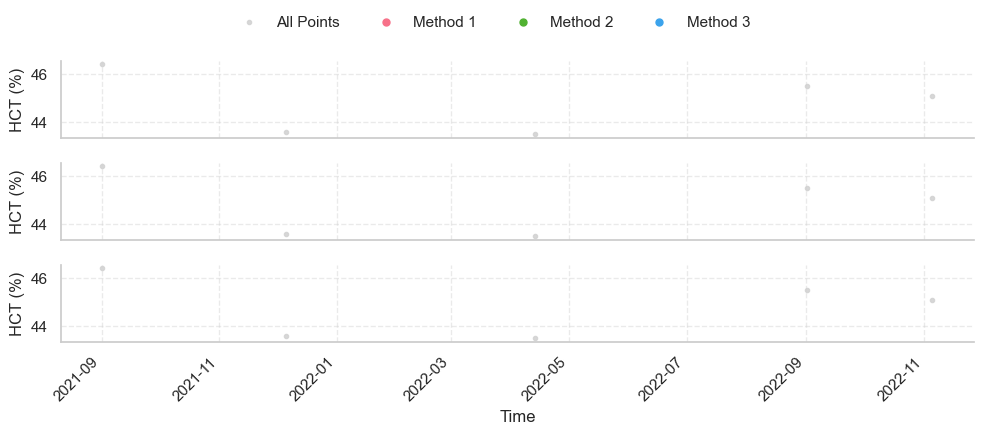

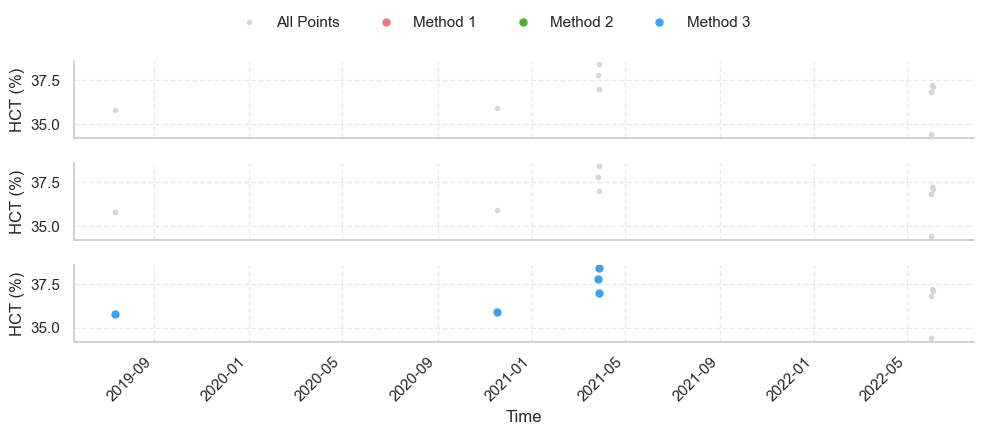

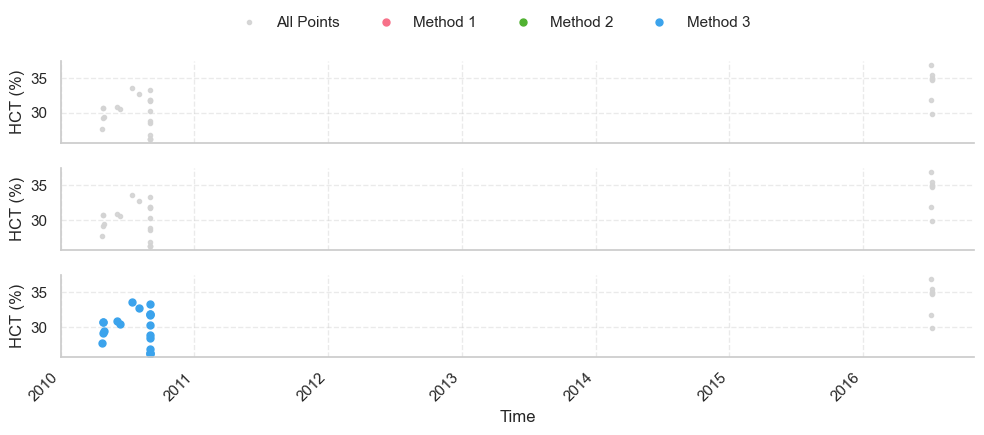

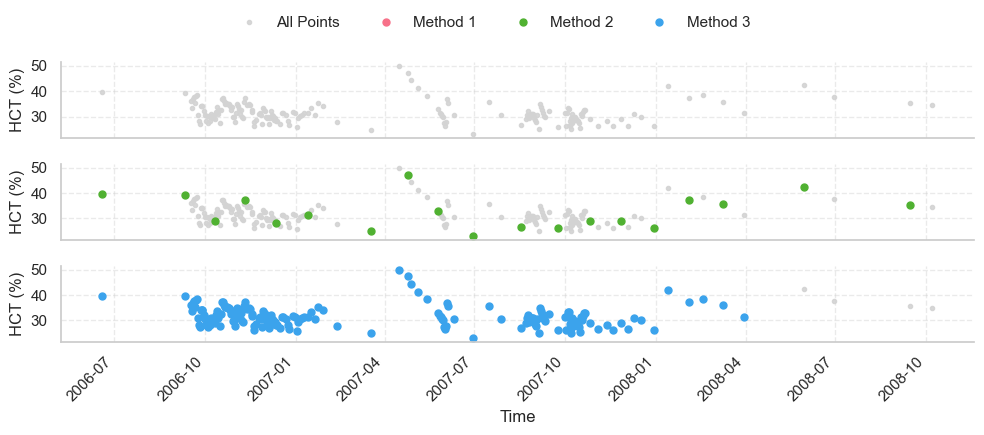

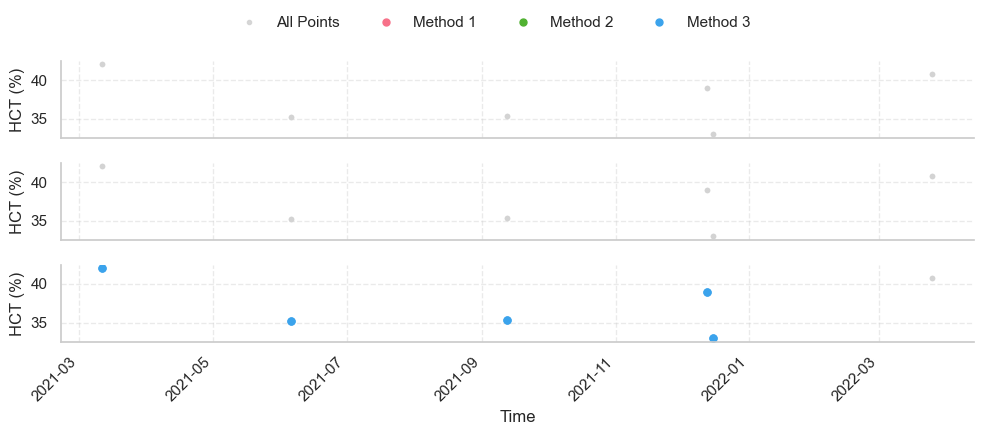

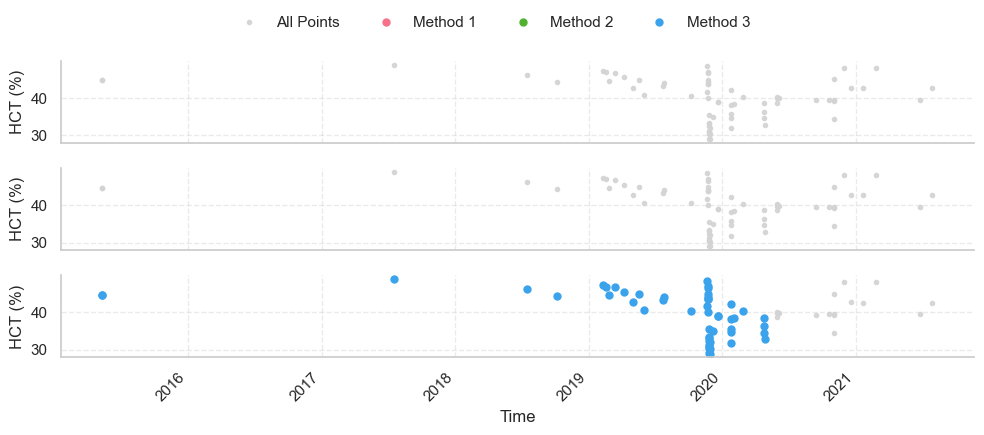

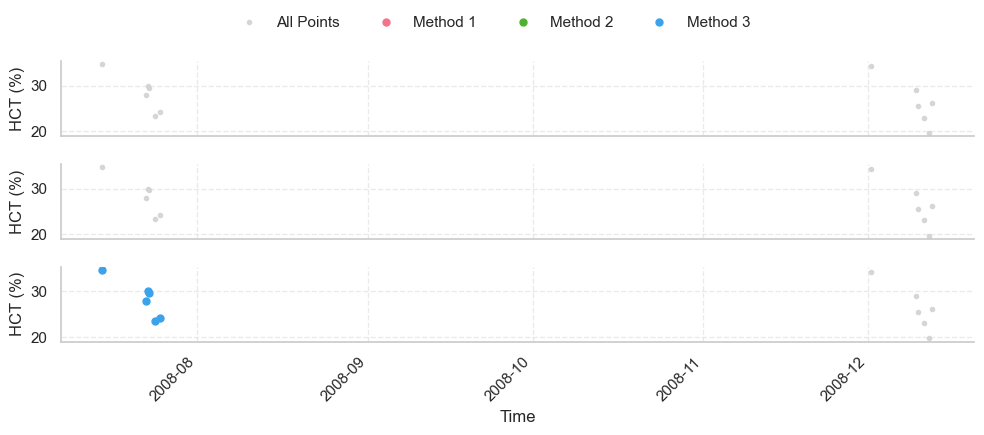

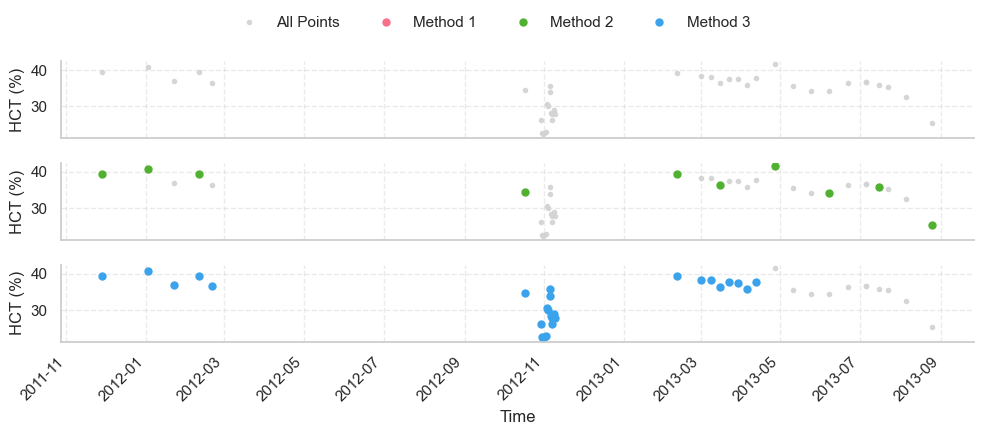

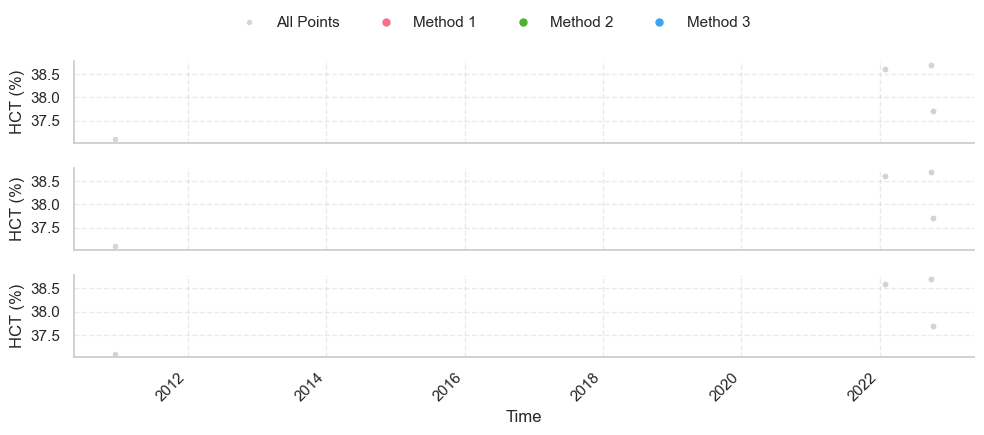

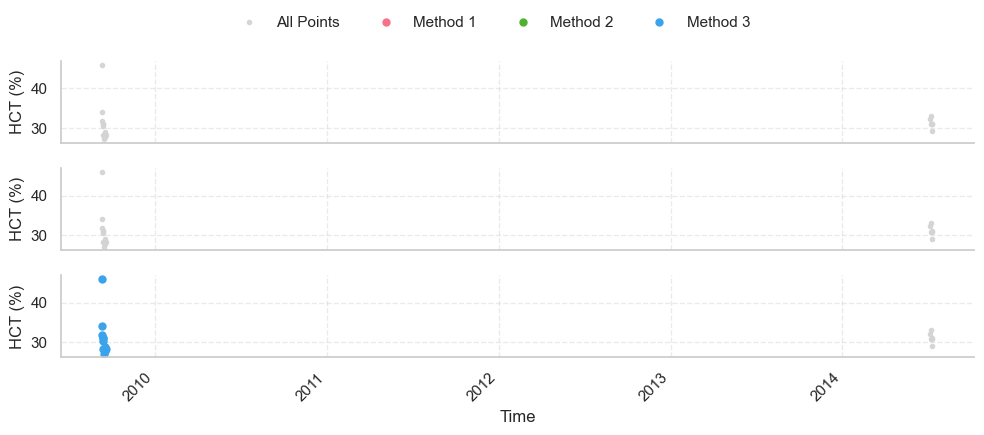

In [12]:
index_year = 2016
day_gap = 0
min_pre_tests = 3

hct_data = lab_measurements[lab_measurements['test_name'] == 'HCT']
sample_subjects = hct_data['subject_id'].unique().sample(1)
sample_data = hct_data[hct_data['subject_id'].isin(sample_subjects)].copy()
sample_data['time'] = pd.to_datetime(sample_data['time'])

methods = {
    'Method 1': (filter_measurements_foy, {'index_year': 2016, 'min_gap': 30, 'min_tests': 5}),
    'Method 2': (filter_measurements_yash, {'index_year': 2016, 'min_gap': 30, 'min_tests': 5}),
    'Method 3': (cutoff_measurements_df, {'percent': 0.8, 'min_tests': 5}),
}

for method, (func, params) in methods.items():
    processed = func(sample_data, **params)
    sample_data[f'in_{method}'] = sample_data.index.isin(processed.index)

sns.set(style='whitegrid', palette='husl', font='Arial')
mpl.rcParams['font.family'] = 'Arial'

for subject in sample_subjects:
    subject_data = sample_data[sample_data['subject_id'] == subject]
    fig, axes = plt.subplots(3, 1, figsize=(10, 4), sharex=True, sharey=True, dpi=100)
    lines = []
    labels = []
    
    for ax, (method, color) in zip(axes, zip(methods.keys(), sns.color_palette('husl', 3))):
        ax.set_facecolor('white')
        gray_line = ax.plot(subject_data['time'], subject_data['numeric_value'], 'o',
                color='lightgray', alpha=0.9, markersize=3)[0]
        
        included = subject_data[f'in_{method}']
        colored_line = ax.plot(subject_data['time'][included], subject_data['numeric_value'][included],
                'o', color=color, markersize=5)[0]

        ax.set_ylabel('HCT (%)')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if ax == axes[0]:
            lines.extend([gray_line, colored_line])
            labels.extend(['All Points', method])
        else:
            lines.append(colored_line)
            labels.append(method)
    
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, 1.05), 
              ncol=4, frameon=False)

    axes[-1].set_xlabel('Time')
    plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout(h_pad=1.5)
    plt.show()


In [85]:
def plot_empirical_bayes(df, test_name, n_subjects=10):
    df = df.copy().query('test_name == @test_name')
    sampled_df = df.groupby('sex').apply(lambda x: x.sample(n_subjects, random_state=42)).reset_index(drop=True)
    fig, (ax_m, ax_f) = plt.subplots(1, 2, figsize=(16, 5))
    np.random.seed(42)
    
    for sex, ax in [('M', ax_m), ('F', ax_f)]:
        sex_df = sampled_df[sampled_df['sex'] == sex] 
        if len(sex_df) == 0:
            continue

        sex_df['y_title'] = sex_df['subject_id'].astype(str) + ' N=' + sex_df['num_measurements'].astype(str)
        y_pos = np.arange(len(sex_df)) * 1.0
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sex_df['y_title'])

        colors = sns.color_palette("husl", 4)
        obs_color, post_color, emp_color, hier_color = colors

        obs_std = np.sqrt(sex_df['obs_var'])
        post_std = np.sqrt(sex_df['post_var'])
        prior_std = np.sqrt(sex_df['prior_var'].iloc[0])
        prior_mean = sex_df['prior_mean'].iloc[0]
        offset = 0.2

        ax.errorbar(sex_df['obs_mean'], y_pos + offset, xerr=2*obs_std, fmt='o', label='Observed (2σ)',
                    color='gray', alpha=0.8, capsize=2)

        ax.errorbar(sex_df['post_mean'], y_pos - offset, xerr=2*post_std, fmt='s', label='Bayes',
                    color=color_dict['post'], alpha=0.8, capsize=2)

        ax.axvline(prior_mean, color=color_dict['prior'], linestyle='--', label=f'Prior mean: {prior_mean:.2f}', alpha=0.6)
        ax.axvspan(prior_mean - 2*prior_std, prior_mean + 2*prior_std, alpha=0.1, color=color_dict['prior'], label='Population')
        
        if 'setpoint_mean' in sex_df.columns:
            setpoint_std = sex_df['setpoint_std']
            ax.errorbar(sex_df['setpoint_mean'], y_pos, xerr=2*setpoint_std, fmt='s', label='Setpoint',
                        color=color_dict['setpoint'], alpha=0.8, capsize=2)
            
        if 'smoothed_mean' in sex_df.columns:
            smoothed_std = np.sqrt(sex_df['smoothed_x_var'])
            ax.errorbar(sex_df['smoothed_x_mean'], y_pos - offset*2, xerr=2*smoothed_std, fmt='s', label='Smoothed',
                        color=color_dict['smoothed'], alpha=0.8, capsize=2)
        
        if 'ou_mean' in sex_df.columns:
            ou_std = sex_df['ou_std']
            ax.errorbar(sex_df['ou_mean'], y_pos - offset*3, xerr=2*ou_std, fmt='s', label='OU',
                        color=color_dict['ou'], alpha=0.8, capsize=2)
        
        if 'empirical_post_mean' in sex_df.columns:
            emp_std = np.sqrt(sex_df['empirical_post_var'])
            ax.errorbar(sex_df['empirical_post_mean'], y_pos + offset*2, xerr=2*emp_std, fmt='s', label='Empirical Posterior',
                        color=color_dict['post'], alpha=0.8, capsize=2)

        if 'hierarchical_post_mean' in sex_df.columns:
            hier_std = np.sqrt(sex_df['hierarchical_post_var'])
            ax.errorbar(sex_df['hierarchical_post_mean'], y_pos + offset*3, xerr=2*hier_std, fmt='s', label='Hierarchical Posterior',
                        color=hier_color, alpha=0.8, capsize=2)

        ax.set_xlabel(f'{test_name} Value')
        ax.set_ylabel('Subject')
        ax.set_title(f'{test_name} - {sex}', fontsize=14)
        ax.grid(True, alpha=0.2)
        ax.legend(loc='upper left', fontsize=9, frameon=False)
        sns.despine()

    plt.suptitle(f'Empirical Bayes for {test_name} by Sex', fontsize=16)
    plt.tight_layout()

    return fig, (ax_m, ax_f)


def plot_ranges(processed_df, reference_data, subject_id, test_name):
    intervals = {
        'prior': ('Population', 1.8),
        'setpoint': ('GMM', 0.0),
        'smoothed': ('Smoothed', 0.6),
        'post': ('Bayes', 1.2),
        'ou': ('OU', 1.4)
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 1.5), dpi=300,
                                  gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.02})
    
    df = processed_df.query(f'subject_id == {subject_id} and test_name == "{test_name}"')
    ranges_df = reference_data.query(f'subject_id == {subject_id} and test_name == "{test_name}"')
    
    ranges = [(ranges_df[f'{k}_mean'].values[0], ranges_df[f'{k}_var'].values[0]) 
             for k in intervals.keys()]
    max_range = max(m + 2*np.sqrt(v) for m,v in ranges)
    min_range = min(m - 2*np.sqrt(v) for m,v in ranges)
    y_vals = np.linspace(min_range - 5, max_range + 5, 300)
    
    colors = sns.color_palette('husl', len(intervals))
    for (interval, (label, pos)), color in zip(intervals.items(), colors):
        mean = ranges_df[f'{interval}_mean'].values[0]
        var = ranges_df[f'{interval}_var'].values[0]
        
        ax1.axhline(y=mean, color=color, linewidth=1.0,
                    label=f'{label}', alpha=0.5)
        
        pdf = norm.pdf(y_vals, mean, np.sqrt(var))
        pdf_scaled = 0.35 * pdf/pdf.max()
        ax2.fill_betweenx(y_vals, pos, pos + pdf_scaled, color=color, alpha=0.5)

    df['time'] = pd.to_datetime(df['time'])
    ax1.scatter(df['time'], df['numeric_value'], s=10, color='gray', alpha=0.9, label='Observed')
    
    ax1.legend(loc='center', bbox_to_anchor=(0.5, 1.05), ncol=5,
               frameon=False, fontsize=8, bbox_transform=fig.transFigure)
    ax1.set_ylabel(test_name, fontsize=8)
    ax1.set_xlabel('Date', fontsize=8)
    ax1.tick_params(axis='both', labelsize=8)
    ax1.grid(True, linestyle='--', alpha=0.15)
    
    buffer = 0.05 * (max_range - min_range)
    for ax in (ax1, ax2):
        ax.set_ylim(min_range - buffer, max_range + buffer)
        for spine in ax.spines.values():
            spine.set_color('#cccccc')
            spine.set_linewidth(0.0)
            
    ax2.set_xlim(0.0, 2.4)
    ax2.set_xticks([])
    ax2.tick_params(left=False, labelleft=False)
    
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

,subject_id,test_name,ou_prior_mean,ou_prior_var,ou_prior_sigma_mean,ou_prior_sigma_var,ou_mean,ou_speed,ou_std,ou_var,n_measurements,dt_mean
0,115967116,HCT,42.00,2.500,2.500,0.2,38.175147,0.159029,2.046766,4.189252,11,84.627210
1,115967116,PT,11.50,0.750,0.750,0.2,13.830395,0.444577,0.614048,0.377055,7,125.702877
2,115967116,WBC,7.75,1.625,1.625,0.2,5.482992,1.487738,1.330440,1.770070,11,84.627210
3,115967124,ALB,4.50,0.500,0.500,0.2,3.517668,3.105771,0.409366,0.167580,4,79.744271
4,115967124,ALP,70.00,20.000,20.000,0.2,70.615825,0.025524,14.293288,204.298089,4,79.744271
...,...,...,...,...,...,...,...,...,...,...,...,...
19035,115973825,RDW,11.75,1.375,1.375,0.2,13.670095,2.768475,1.125755,1.267324,5,240.031528
19036,115973825,TBIL,0.15,0.075,0.075,0.2,0.629129,0.096176,0.061405,0.003771,7,171.451091
19037,115973825,TP,7.00,0.500,0.500,0.2,7.984606,1.786428,0.409365,0.167580,7,171.451091
19038,115973825,WBC,7.75,1.625,1.625,0.2,6.789033,3.352099,1.330438,1.770065,5,240.031528


Number of subjects in the reference data: 1065


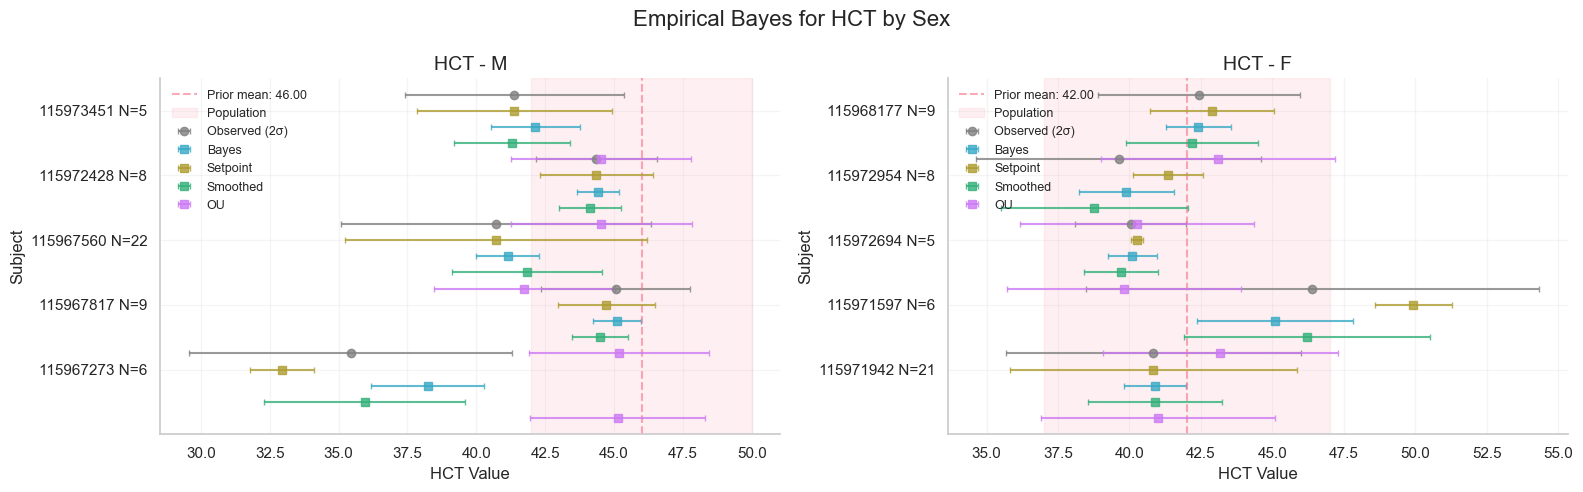

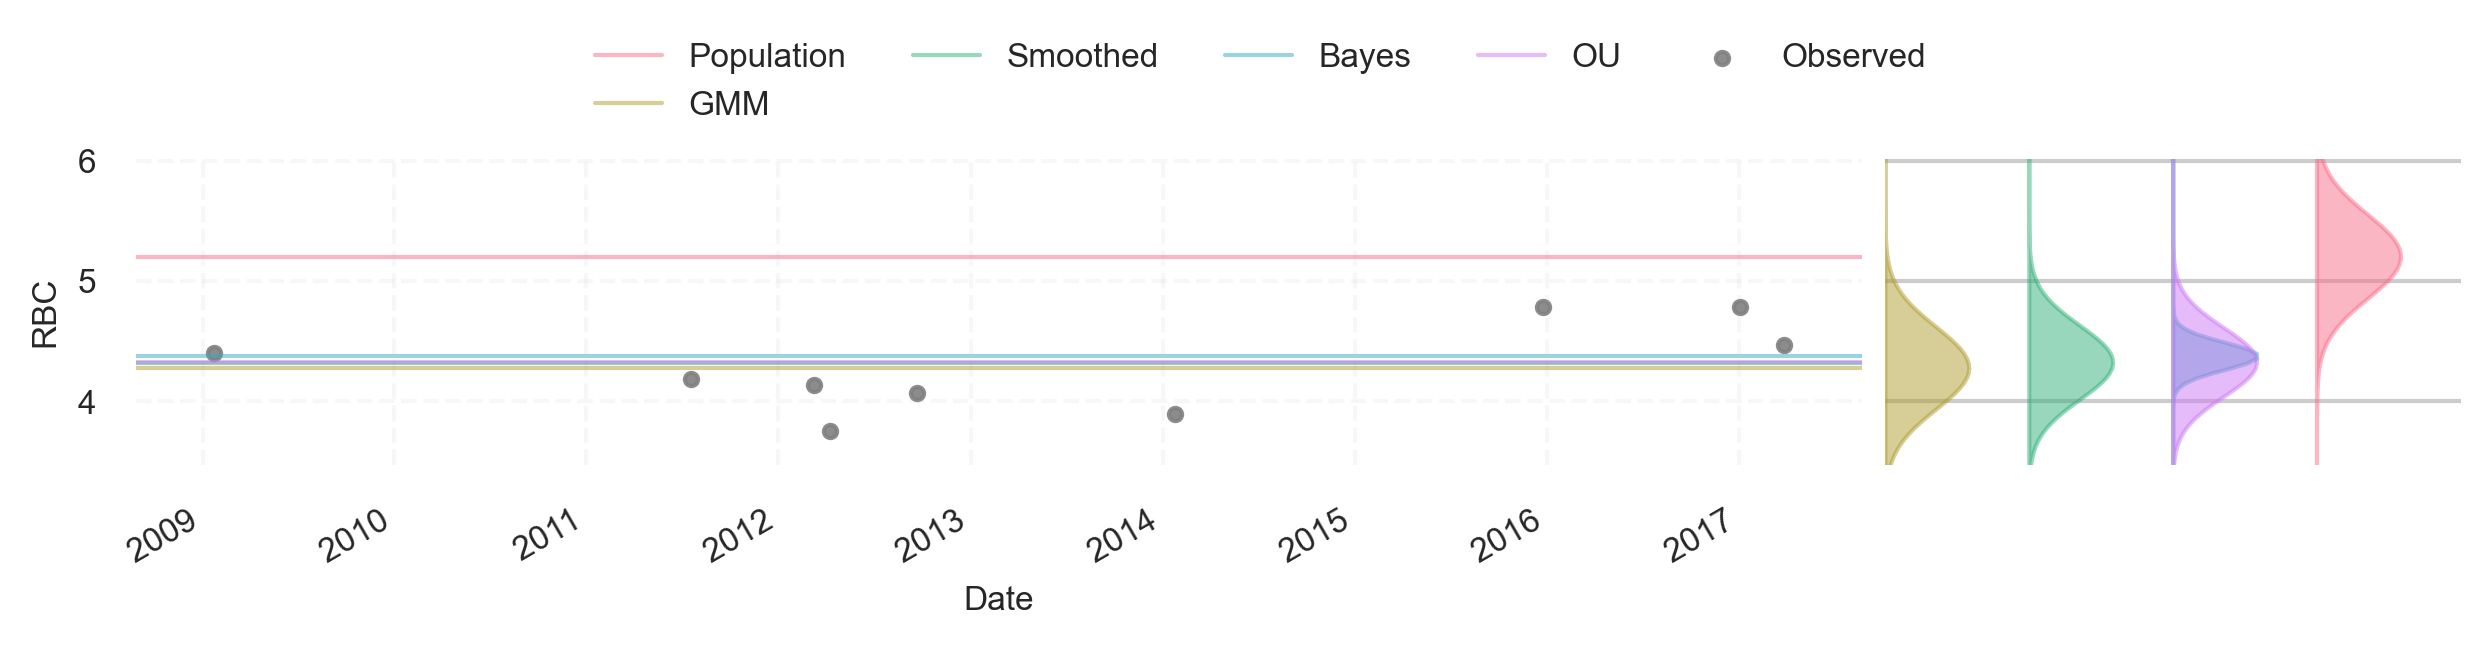

In [80]:
min_tests = 5
method_str = f'method:index_foy_index_year:2016_min_gap:30_min_tests:{min_tests}'
reference_data = read_reference_data(method_str)
print(f'Number of subjects in the reference data: {reference_data["subject_id"].nunique()}')


plot_empirical_bayes(reference_data, 'HCT', n_subjects=5)

subject_id = 115973741
test_name = 'RBC'
plot_ranges(foy_measurements, reference_data, subject_id, test_name)

,subject_id,test_name,ou_prior_mean,ou_prior_var,ou_prior_sigma_mean,ou_prior_sigma_var,ou_mean,ou_speed,ou_std,ou_var,n_measurements,dt_mean
0,115967096,CRE,0.80,0.150,0.150,0.2,0.932678,3.392842,0.122810,0.015082,4,420.495833
1,115967103,ALB,4.50,0.500,0.500,0.2,3.924745,0.241666,0.409405,0.167613,5,48.825278
2,115967103,ALP,70.00,20.000,20.000,0.2,73.860698,1.473983,16.374611,268.127879,5,48.825278
3,115967103,ALT,25.00,7.500,7.500,0.2,25.324768,0.011616,3.788764,14.354736,5,48.825278
4,115967103,AST,25.00,7.500,7.500,0.2,18.639997,10.248251,6.140474,37.705415,5,48.825278
...,...,...,...,...,...,...,...,...,...,...,...,...
28722,115973826,RBC,5.20,0.350,0.350,0.2,4.662952,0.133779,0.286480,0.082071,8,84.768316
28723,115973826,RDW,11.75,1.375,1.375,0.2,12.049140,0.004975,0.579347,0.335643,8,84.768316
28724,115973826,TBIL,0.15,0.075,0.075,0.2,0.364021,0.338924,0.061405,0.003771,7,73.517956
28725,115973826,TP,7.00,0.500,0.500,0.2,7.420387,0.906921,0.409366,0.167580,7,73.517956


Number of subjects in the reference data: 1438


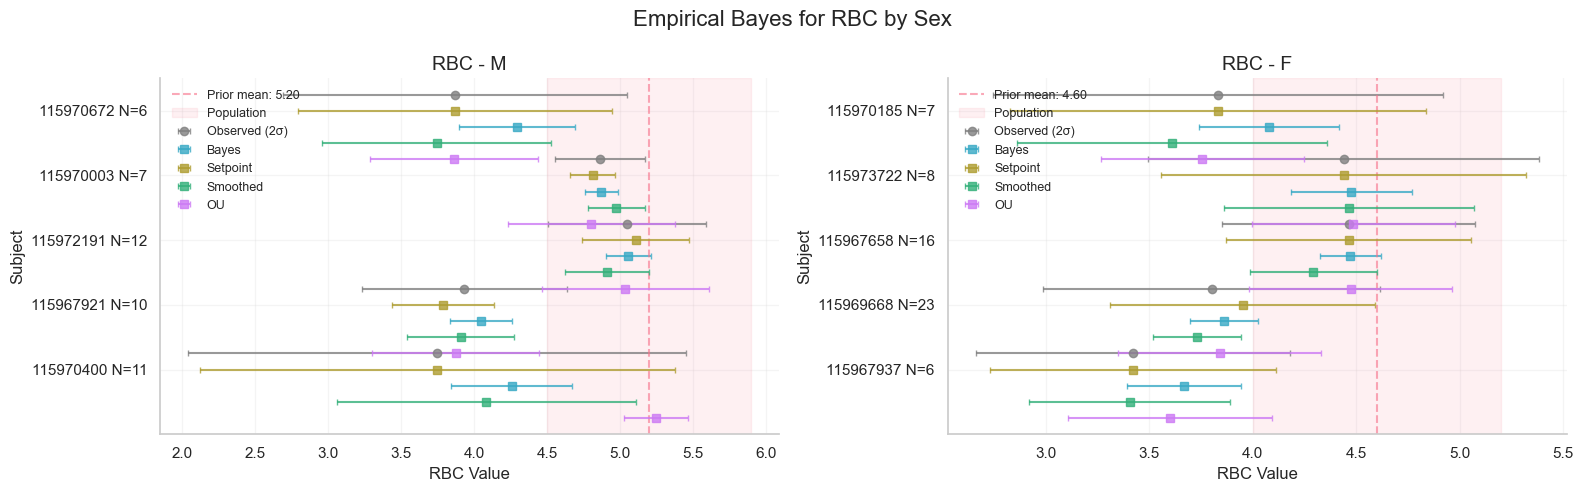

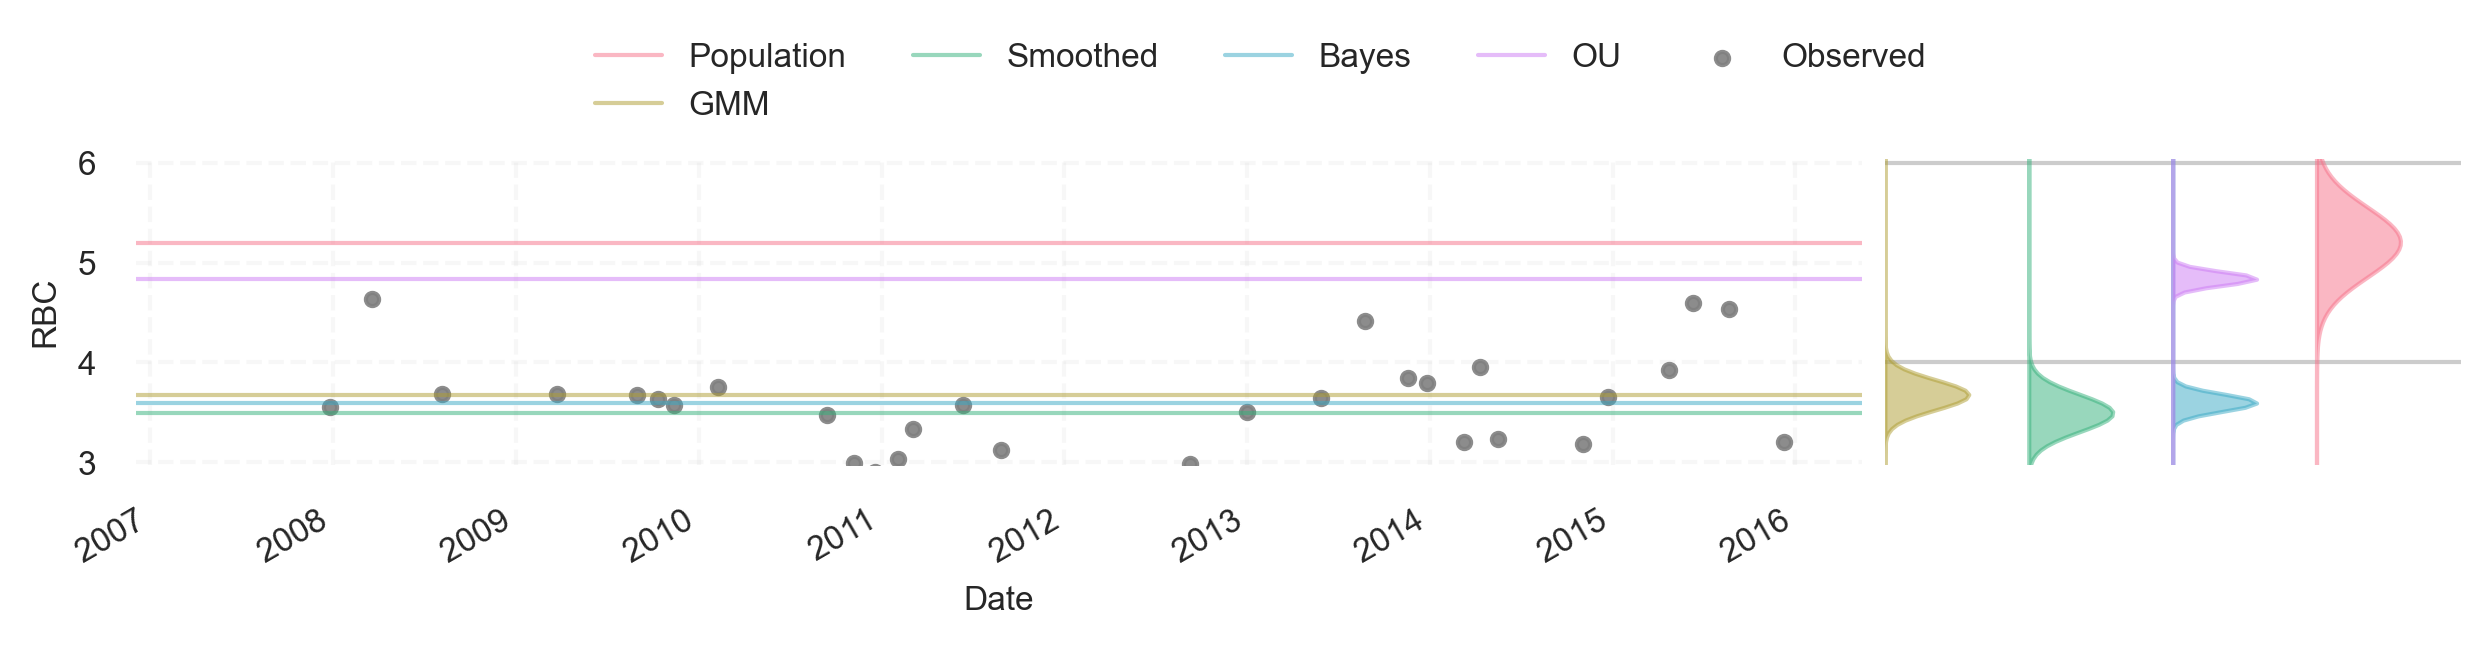

In [81]:
min_tests = 5
method_str = f'method:index_index_year:2016_min_gap:30_min_tests:{min_tests}'
reference_data = read_reference_data(method_str)

# print the number of subjects in the reference data
print(f'Number of subjects in the reference data: {reference_data["subject_id"].nunique()}')

plot_empirical_bayes(reference_data, 'RBC', n_subjects=5)
subject_id = 115967430
test_name = 'RBC'
plot_ranges(yash_measurements, reference_data, subject_id, test_name)



Number of subjects in the reference data: 1438


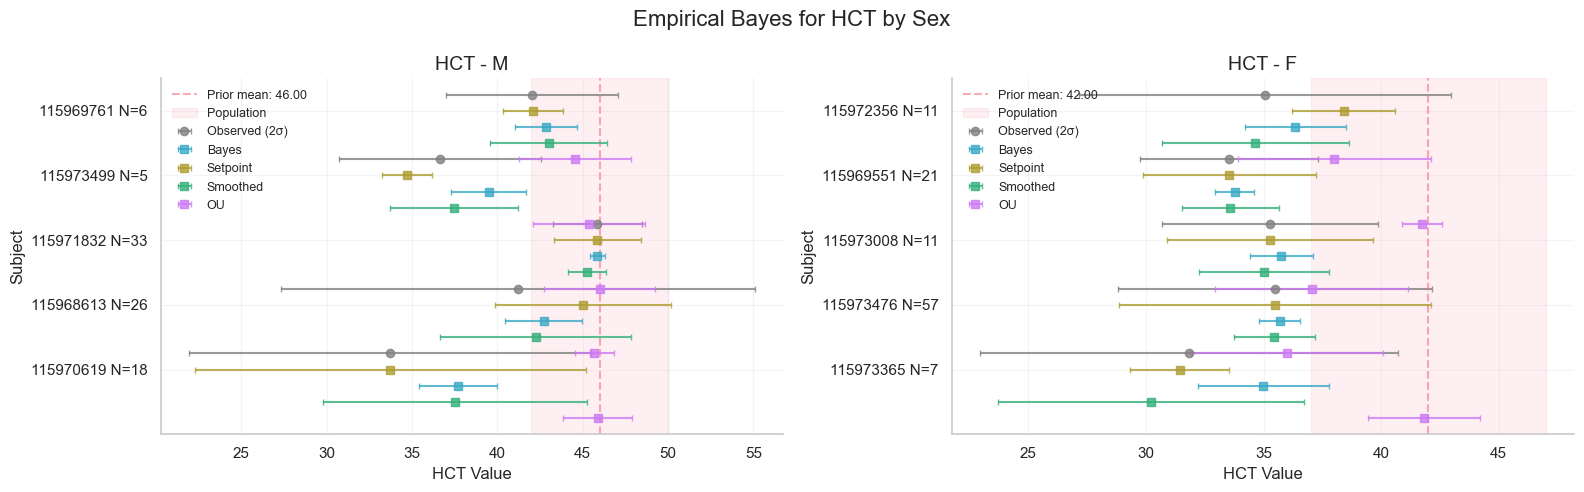

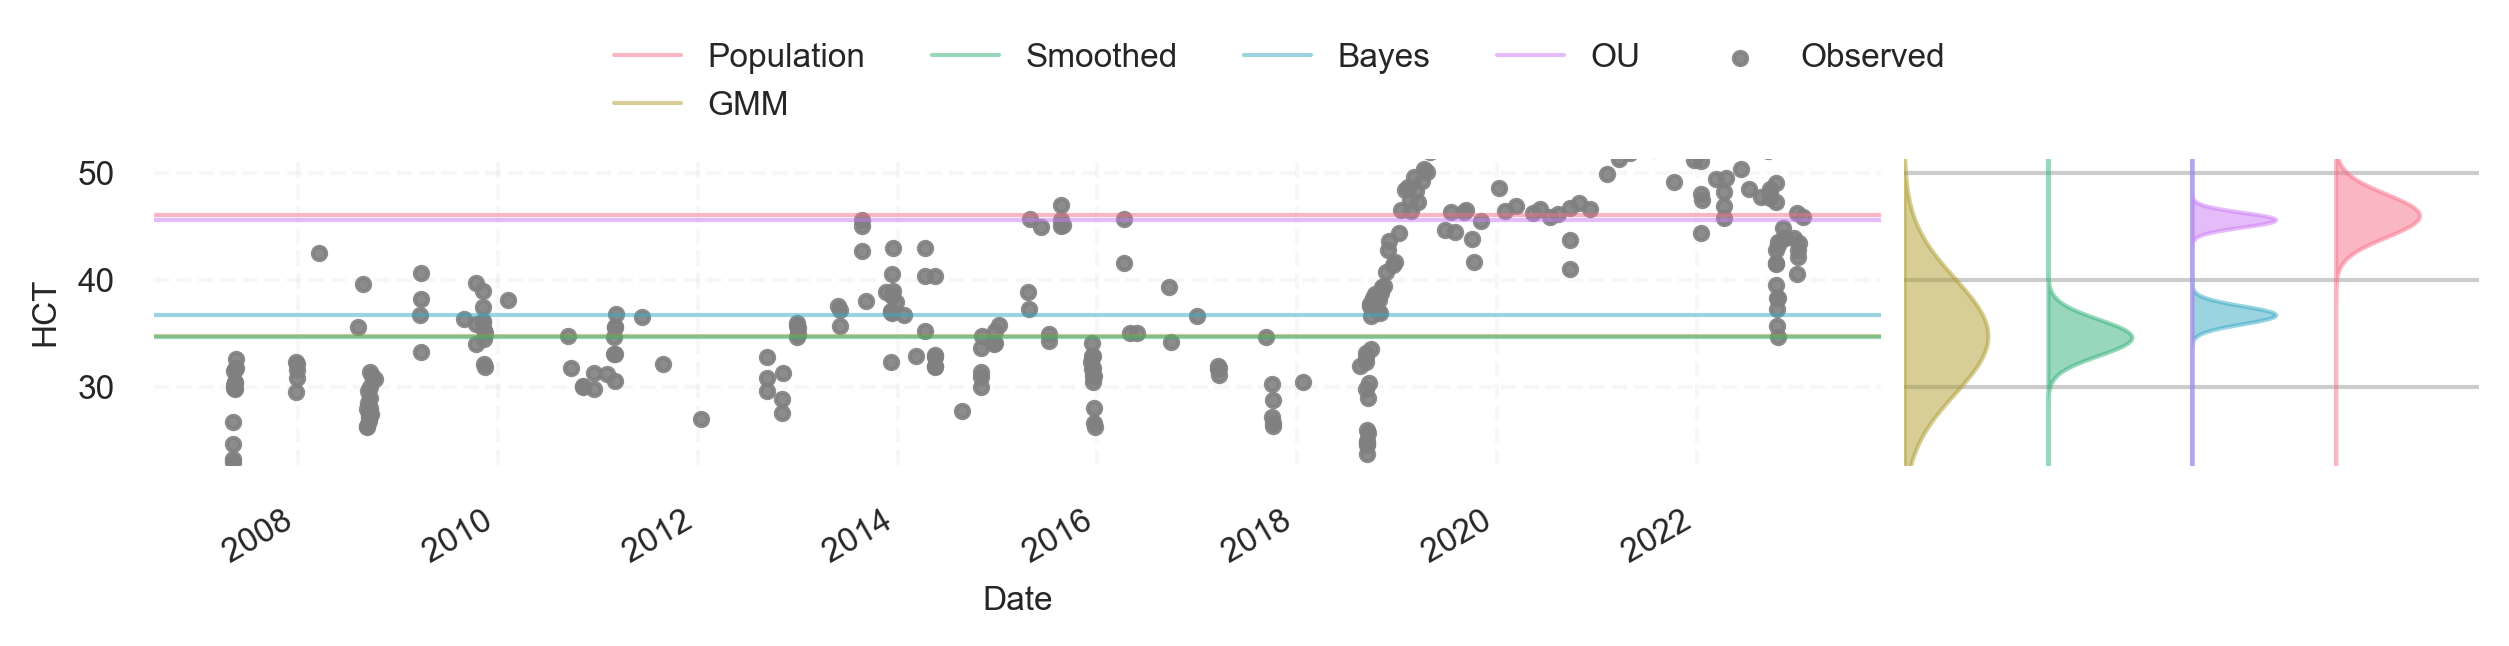

In [84]:
method_str = f'method:cutoff_percent:0.8_min_tests:5'


# print the number of subjects in the reference data
print(f'Number of subjects in the reference data: {reference_data["subject_id"].nunique()}')

plot_empirical_bayes(reference_data, 'HCT', n_subjects=5)
subject_id = 115967430
test_name = 'HCT'

# Plot each pair
plot_ranges(lab_measurements, reference_data, subject_id, test_name)


In [ ]:
115969474

,subject_id,test_name,ou_prior_mean,ou_prior_var,ou_prior_sigma_mean,ou_prior_sigma_var,ou_mean,ou_speed,ou_std,smoothed_curve,...,num_measurements,last_time,time_period_days,obs_mean,obs_var,prior_mean,prior_var,w,post_mean,post_var
0,115967095,BUN,14.00,2.250000,1.5000,0.2,13.996538,0.001000,1.254221,[15.95678541 14.71091979 11.01076733 10.273234...,...,7,2008-10-13 06:56:00,5,11.571429,4.952381,14.00,9.000000,0.927120,11.748423,0.655922
1,115967095,CA,9.40,0.040000,0.2000,0.2,9.397415,0.062338,0.266217,[7.18061988 7.17078051 7.18320218 7.14104385 7...,...,7,2008-10-13 06:56:00,5,7.285714,0.078095,9.40,0.160000,0.934817,7.423529,0.010429
2,115967095,CL,102.00,1.000000,1.0000,0.2,101.998862,0.001000,2.091711,[103.24043995 103.08662181 102.82607305 99.88...,...,7,2008-10-13 06:56:00,5,100.428571,6.952381,102.00,4.000000,0.801090,100.741144,0.795640
3,115967095,CO2,25.50,0.390625,0.6250,0.2,25.754768,0.549668,1.214973,[23.98913379 23.49008249 22.00691741 24.992947...,...,7,2008-10-13 06:56:00,5,24.571429,3.952381,25.50,1.562500,0.734559,24.817909,0.414751
4,115967095,CRE,0.80,0.005625,0.0750,0.2,0.795686,0.328761,0.097030,[0.8 0.77497013 0.7 0.62810507 0...,...,7,2008-10-13 06:56:00,5,0.671429,0.009048,0.80,0.022500,0.945675,0.678413,0.001222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72920,115973826,RBC,5.20,0.030625,0.1750,0.2,5.172659,0.002446,0.093597,[5.18553161 5.13946439 5.13937915 5.28457052 5...,...,51,2016-05-21 14:42:00,852,4.197843,0.464233,5.20,0.122500,0.930833,4.267160,0.008473
72921,115973826,RDW,11.75,0.472656,0.6875,0.2,11.792839,0.001430,0.379277,[16.17523738 15.92936038 15.92886875 15.234297...,...,51,2016-05-21 14:42:00,852,17.864706,5.624329,11.75,1.890625,0.944884,17.527691,0.104203
72922,115973826,TBIL,0.15,0.001406,0.0375,0.2,0.161911,0.007620,0.038126,[0.31871001 0.3188632 0.51495956 0.49102325 0...,...,41,2016-06-25 11:23:00,723,0.421951,0.017256,0.15,0.005625,0.930386,0.403019,0.000392
72923,115973826,TP,7.00,0.062500,0.2500,0.2,7.273504,0.075356,0.180472,[7.5461331 7.54594208 7.41469622 7.39727003 7...,...,41,2016-06-25 11:23:00,723,7.329268,0.210122,7.00,0.250000,0.979912,7.322654,0.005022
